In [1]:
import gensim
import fasttext.util
import pandas as pd
import numpy as np

### read the mordality norms datasets downloaded from : https://github.com/bodowinter/affect_modality
There are 3 seperate files corresponding to verbs, nouns and adjcetives.

These files contain words and their corresponding perceptual strength(Auditory, Visual, Haptic, Gustatory and olfactory) collected by asking many participants. We will consider these files as reference files and will use them to compare to compare the efficacy of our proposed method. Details can be found in [Bodo Winter, 2016, Taste and smell words form an affectively loaded and emotionally flexible part of the English lexicon]

We will also attempt to use The Lancaster Sensorimotor Norms for 40k words as reference.  https://link.springer.com/article/10.3758/s13428-019-01316-z 

We will use word embedding based approach to calculate the sensory scores. Two set of pre-trained embeddings have been used
* Fasttext https://fasttext.cc/docs/en/crawl-vectors.html
* Google news https://code.google.com/archive/p/word2vec/ 





In [107]:

form = 'adj'

if form == 'verb':
    data= pd.read_csv('winter_2015_verb_norms.csv')
elif form == 'adj':
    data = pd.read_csv('lynott_connell_2009_adj_norms.csv')
elif form == 'noun':
    data = pd.read_csv('lynott_connell_2013_noun_norms.csv')
elif form == 'all':
    data= pd.read_csv('winter_lynott_verb_adj_noun.csv')
elif form == 'sensori':
    data= pd.read_csv('Sensorimotor_norms_25Jan2020.csv')
    data.rename(columns={"Auditory.mean": "AuditoryStrengthMean", "Gustatory.mean": "GustatoryStrengthMean", 
                    "Haptic.mean":"HapticStrengthMean", "Olfactory.mean":"OlfactoryStrengthMean",
                     "Visual.mean":"VisualStrengthMean" }, inplace=True)

print(data.shape)
words=data['Word'].values.tolist()# words for which perceptual strength will be calculated


data.head()

(423, 9)


PropertyBritish       Word DominantModality  VisualStrengthMean  \
0        abrasive   abrasive           Haptic            2.894737   
1       absorbent  absorbent           Visual            4.142857   
2          aching     aching           Haptic            2.047619   
3          acidic     acidic        Gustatory            2.190476   
4           acrid      acrid        Olfactory            1.125000   

   HapticStrengthMean  AuditoryStrengthMean  GustatoryStrengthMean  \
0            3.684211              1.684211               0.578947   
1            3.142857              0.714286               0.476190   
2            3.666667              0.666667               0.047619   
3            1.142857              0.476190               4.190476   
4            0.625000              0.375000               3.000000   

   OlfactoryStrengthMean  ModalityExclusivity  
0               0.578947             0.329609  
1               0.476190             0.409574  
2               0.095238             0.554745  
3               2.904762             0.340611  
4               3.500000             0.362319

## seed words which will be mapped to different modalities

The words were selected from Bodo Winter, 2016 paper. He used these words for creating dictionary of verbs. We can experiment with different words for nouns and adjectives but it doesnt work well. we are taking the basic verb words i.e. see, hear, touch, taste and smell. 

### verbs
* Visual -> ['see', 'look']
* Auditory -> ['hear', 'listen', 'sound']
* Haptic -> ['feel', 'touch']
* Olfactory -> ['smell']
* Gustatory ->['taste']

### adjectives
* Visual ->['bright']
* Auditory -> ['barking']
* Haptic -> ['smooth']
* Olfactory -> ['fragrant']
* Gustatory -> ['citrusy']

### nouns 
* Visual -> ['reflection']
* Auditory -> ['sound']
* Haptic -> ['hold']
* Olfactory -> ['air', 'breath']
* Gustatory -> ['taste']



In [108]:

percept_seed2percept_cat = {'Visual':['see', 'look'], 'Auditory': ['hear','listen','sound'], 
                            'Haptic': ['feel', 'touch'], 'Gustatory': ['taste'], 'Olfactory': ['smell']} # well with adjectives and nouns

#percept_seed2percept_cat = {'Visual':['see'], 'Auditory': ['hear'], 
#                            'Haptic': [ 'touch'], 'Gustatory': ['taste'], 'Olfactory': ['smell']} # performs well with verbs

#percept_seed2percept_cat = {'Visual':['bright'], 'Auditory': ['barking'], 
#                            'Haptic': [ 'smooth'], 'Gustatory': ['citrusy'], 'Olfactory': ['fragrant']}  # adj, but worse than the full verb list

#percept_seed2percept_cat = {'Visual':['reflection'], 'Auditory': ['sound'], 
#           'Haptic': [ 'hold'], 'Gustatory': ['taste'], 'Olfactory': ['air', 'breath']} # noun but worse than full verb list


mapwords={}
for k,vlist in percept_seed2percept_cat.items():
    for v in vlist:
        mapwords[v] = k

perceptual_seedwords = list(mapwords.keys())

mapwords, perceptual_seedwords

({'see': 'Visual',
  'look': 'Visual',
  'hear': 'Auditory',
  'listen': 'Auditory',
  'sound': 'Auditory',
  'feel': 'Haptic',
  'touch': 'Haptic',
  'taste': 'Gustatory',
  'smell': 'Olfactory'},
 ['see', 'look', 'hear', 'listen', 'sound', 'feel', 'touch', 'taste', 'smell'])

In [4]:
# to calculate cosine similarity between 2 vectors
def similarity(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    return np.dot(v1, v2) / n1 / n2

## read pre-trained models 
### fasttext

In [5]:
#model = fasttext.train_supervised(input="cooking.train")
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

### calculate cosine similarity between perceptual seed words and words.
sim_df_ft dataframe

In [119]:
add_vectors=False
if add_vectors:
    sim_df_ft = pd.DataFrame(index= words, dtype= 'float')
    for word in words:
        v1 = ft.get_word_vector(word)
        v2 = np.zeros(v1.shape)
        for perceptlist in percept_seed2percept_cat.values():
            for percept in perceptlist:
                v2+=ft.get_word_vector(percept)
            v2= np.divide(v2, len(perceptlist))
            sim_df_ft.loc[word, percept] = similarity(v1, v2) 
                

else:
    sim_df_ft = pd.DataFrame(index= words, columns = perceptual_seedwords, dtype= 'float')
    for word in words:
        for percept in perceptual_seedwords:    
            v1 = ft.get_word_vector(word)
            v2 = ft.get_word_vector(percept)
            sim_df_ft.loc[word, percept] = similarity(v1, v2)
sim_df_ft       

see      look      hear    listen     sound      feel  \
abrasive  -0.025544  0.056760  0.129588  0.196421  0.267560  0.186331   
absorbent -0.048023  0.076433  0.035628 -0.029664  0.127456  0.113974   
aching     0.105631  0.129979  0.205617  0.137786  0.143028  0.348631   
acidic    -0.019996  0.046048  0.033611  0.037176  0.193860  0.170181   
acrid      0.003705  0.063358  0.132473  0.050316  0.256233  0.189565   
...             ...       ...       ...       ...       ...       ...   
wiry       0.055499  0.130869  0.071153  0.043792  0.146190  0.127264   
wispy      0.100605  0.228359  0.121256  0.065846  0.234159  0.193336   
wizened    0.097775  0.218433  0.110705  0.137786  0.135757  0.092825   
woolly    -0.006752  0.106297  0.045816  0.029819  0.221940  0.176423   
yellow     0.124974  0.160473 -0.006664 -0.025304  0.106771  0.072036   

              touch     taste     smell  
abrasive   0.172454  0.138532  0.115839  
absorbent  0.158682  0.109968  0.212868  
aching     0.242876  0.150557  0.165108  
acidic     0.171577  0.313436  0.260999  
acrid      0.192981  0.431422  0.501199  
...             ...       ...       ...  
wiry       0.164123  0.114417  0.154310  
wispy      0.207086  0.134300  0.215283  
wizened    0.138762  0.136239  0.140065  
woolly     0.140693  0.125286  0.147590  
yellow     0.206401  0.151280  0.201114  

[423 rows x 9 columns]

In [34]:
sim_df_ft.corr()

see      hear     touch     taste     smell
see    1.000000  0.339940 -0.048483 -0.316833 -0.238401
hear   0.339940  1.000000 -0.131456 -0.086364  0.198143
touch -0.048483 -0.131456  1.000000  0.373698  0.223980
taste -0.316833 -0.086364  0.373698  1.000000  0.676300
smell -0.238401  0.198143  0.223980  0.676300  1.000000

In [110]:
def prepare_data(sim_df, data, mapwords):
    
    columns = ['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean', 'OlfactoryStrengthMean',
       'GustatoryStrengthMean']
    
    sim_df = pd.concat([sim_df, pd.DataFrame(columns = columns)], sort=False)
    
    sim_df[columns] = data[columns].apply(pd.to_numeric).values
    
    
    return sim_df 


def add_dominantmod(sim_df, data,perceptual_seedwords):
           
    sim_df['DM_word2vec'] = sim_df[perceptual_seedwords].idxmax(axis=1).apply(lambda x: mapwords[x])
    print(sim_df.groupby("DM_word2vec").idxmax())

    print(sim_df.groupby("DM_word2vec").mean())
    if 'DominantModality' in data.columns:
        print('Dominant Modality exists in reference data \n ')
    else:
        data['DominantModality'] = data[['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean', 'OlfactoryStrengthMean',
           'GustatoryStrengthMean']].idxmax(axis=1).apply(lambda x: x.replace('StrengthMean', ''))
        print('Calculated dominant modality in reference data and added as a new column to data' )
    
    sim_df['DominantModality'] = data['DominantModality'].values
    print('Dominant modality count as per word2vec\n', sim_df['DM_word2vec'].value_counts())
    print('Dominant modailty count as per reference data \n ', sim_df['DominantModality'].value_counts())
    return sim_df
    
    
def normdata(df,perceptual_seedwords, preprocess):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
    normdf = pd.DataFrame(df, columns= df.columns, index = df.index)
    columns_ref = ['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean', 'OlfactoryStrengthMean',
       'GustatoryStrengthMean']
    #
    if preprocess ==1:
        normdf[columns_ref] = normalize(df[columns_ref].values, norm='l2')
        normdf[perceptual_seedwords]= normalize(df[perceptual_seedwords], norm='l2')
    elif preprocess == 2:
        normdf[columns_ref] = StandardScaler().fit_transform(df[columns_ref].values)
        normdf[perceptual_seedwords]= StandardScaler().fit_transform(df[perceptual_seedwords])
        
    #temp1= normalize(temp, norm='l2')
    
    return normdf

In [124]:
preprocess= 2
sim_df_ft = prepare_data(sim_df_ft,data, mapwords)
temp = normdata(sim_df_ft,perceptual_seedwords, preprocess )
#temp=sim_df_ft
sim_df_ft_final = add_dominantmod(temp, data,perceptual_seedwords)


sim_df_ft_final.isnull().sum()

                 see       look      hear   listen    sound       feel  \
DM_word2vec                                                              
Auditory     whining     cheesy      loud  blaring  muffled     mellow   
Gustatory      nutty  delicious     nutty  honeyed    nutty  delicious   
Haptic         happy      happy     happy    happy    crisp      happy   
Olfactory      fishy      fishy  snorting  flowery    fishy      fishy   
Visual        little     little   strange     hard  strange     little   

               touch    taste    smell VisualStrengthMean HapticStrengthMean  \
DM_word2vec                                                                    
Auditory        mute  insipid  hissing            compact             thorny   
Gustatory    buttery    salty    minty          barbecued            boiling   
Haptic          warm    sweet   earthy           spotless             smooth   
Olfactory    scented  pungent  odorous              khaki           leathery   
V

see                      0
look                     0
hear                     0
listen                   0
sound                    0
feel                     0
touch                    0
taste                    0
smell                    0
VisualStrengthMean       0
HapticStrengthMean       0
AuditoryStrengthMean     0
OlfactoryStrengthMean    0
GustatoryStrengthMean    0
DM_word2vec              0
DominantModality         0
dtype: int64

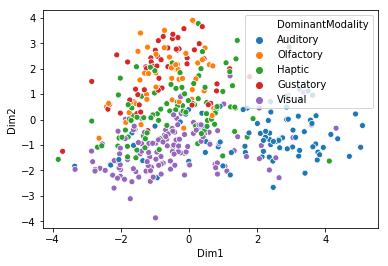

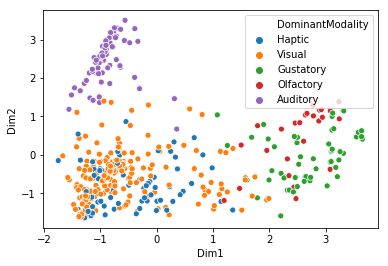

In [129]:
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import seaborn as sns
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
#plotvar = region2spiceingre_df_combined.T




def myplot(plotvar, color_label):
    n_components=3
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(plotvar)
    
    plot_df = pd.DataFrame(principalComponents[:,[0,1]], columns=['Dim1', 'Dim2'])
    plot_df['DominantModality'] = color_label.values
    sns.scatterplot(x='Dim1', y='Dim2', data = plot_df, hue= 'DominantModality')
    
      

plotvar = sim_df_ft_final[perceptual_seedwords]
color_label = sim_df_ft_final['DM_word2vec']
myplot(plotvar, color_label)
plt.show()

plotvar = sim_df_ft_final[['VisualStrengthMean', 'HapticStrengthMean', 'AuditoryStrengthMean', 'OlfactoryStrengthMean',
       'GustatoryStrengthMean']]
color_label = sim_df_ft_final['DominantModality']
myplot(plotvar, color_label)


### calculate performance measures. Compare the scores generated by our proposed method with reference scores

In [126]:

def calc_perf(sim_df):
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score
    
    print('balanced accuracy score\n', balanced_accuracy_score( sim_df['DominantModality'], sim_df['DM_word2vec']))
    print('confusion matrix\n', confusion_matrix( sim_df['DominantModality'], sim_df['DM_word2vec'],labels = ['Visual', 'Auditory',
                                                                                  'Haptic', 'Olfactory', 'Gustatory']))
    print('classification report \n',classification_report(sim_df['DM_word2vec'], sim_df['DominantModality']))
    #fpr, tpr = roc_curve(sim_df['DominantModality'], sim_df['DM_word2vec'])
    #plt.plot(fpr, tpr)
    from sklearn.preprocessing import label_binarize
    label_binarize([1, 6], classes=[1, 2, 4, 6])
    y_test = label_binarize(sim_df['DominantModality'].values, classes =['Visual', 'Auditory',
                                                                                  'Haptic', 'Olfactory', 'Gustatory'] )
    y_prob = label_binarize(sim_df['DM_word2vec'].values, classes =['Visual', 'Auditory',
                                                                                  'Haptic', 'Olfactory', 'Gustatory'] )
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                         average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
    
    
calc_perf(sim_df_ft_final)

balanced accuracy score
 0.791935873786663
confusion matrix
 [[121  13  46  17   8]
 [  2  65   0   1   0]
 [  8   8  46   6   2]
 [  1   0   1  24   0]
 [  2   1   3   3  45]]
classification report 
               precision    recall  f1-score   support

    Auditory       0.96      0.75      0.84        87
   Gustatory       0.83      0.82      0.83        55
      Haptic       0.66      0.48      0.55        96
   Olfactory       0.92      0.47      0.62        51
      Visual       0.59      0.90      0.71       134

    accuracy                           0.71       423
   macro avg       0.79      0.68      0.71       423
weighted avg       0.75      0.71      0.71       423

One-vs-One ROC AUC scores:
0.860132 (macro),
0.820821 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.860132 (macro),
0.820821 (weighted by prevalence)


## repeat with google tre-trained model

In [ ]:
import gensim.models.keyedvectors as word2vec
model = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


### calculate cosine similarity between perceptual seed words and words.
sim_df_google dataframe

In [ ]:
add_vectors=False
if add_vectors:
    sim_df_google = pd.DataFrame(index= words, dtype= 'float')
    for word in words:
        if word in model.vocab:
            v1 = model.get_vector(word)
            v2 = np.zeros(v1.shape)
            for perceptlist in percept_seed2percept_cat.values():
                for percept in perceptlist:
                        v2+=model.get_vector(percept)
        
                v2= np.divide(v2, len(perceptlist))
                sim_df_google.loc[word, percept] = similarity(v1, v2)
        else:
            print('word not found', word)
            sim_df_google.loc[word, percept] = 0
                
else:

    sim_df_google = pd.DataFrame(index= words, columns = perceptual_seedwords, dtype= 'float')
    for word in words:
        for percept in perceptual_seedwords:    
            if (word in model.vocab) & (percept in model.vocab):
                v1 = model.get_vector(word)
                v2 = model.get_vector(percept)
                sim_df_google.loc[word, percept] = similarity(v1, v2)
            else:
                print('words not found', word, percept)
                sim_df_google.loc[word, percept] = 0

sim_df_google 

In [ ]:
# prepare data
sim_df_google.isnull().sum()
sim_df_google = prepare_data(sim_df_google, mapwords)


In [ ]:
# calculate performance
calc_perf(sim_df_google)

In [ ]:
import seaborn as sns
sns.regplot(x='OlfactoryStrengthMean', y= 'smell', data=sim_df)

In [ ]:
from sklearn.metrics import r2_score
from numpy import cov
cov(  sim_df['GustatoryStrengthMean'], sim_df['taste'])